<h4>Tranfer Learning</h4>

<p> Zie <a href="https://www.tensorflow.org/tutorials/images/transfer_learning">LINK</a> voor transfer learning op Tensorflow.

In [262]:
# load Tensorboard
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [263]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, AvgPool2D, Input, Dropout, Flatten, BatchNormalization
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pathlib
import os
import datetime

In [264]:
# Opzet datum voor het opslaan van een bestand.
from datetime import datetime 
now = datetime.now()

# dd/mm/YY
time_save = now.strftime("%Hh%M")
dt_save = now.strftime("%d%m%Y")
# print("ddmmyyyy =", dt_save)
# print("HMS =", time_save)

# folder path to save model 
sp_model = r'saved_models/tl_mobileNetV2_2/model/'
sc_model = 0
# Iterate directory
for path in os.listdir(sp_model):
    # check if current path is a file
    if os.path.isfile(os.path.join(sp_model, path)):
        sc_model += 1
# print('File count:', sc_model)

<h4>Warning blokker</h4>
<p>De lagen in een model geven een warning. De code hieronder blokced het tonen hiervan.</p>    
    

In [265]:
tf.get_logger().setLevel('ERROR')

In [266]:
# load dataset 

test_data_dir = '../data/Test'
train_data_dir = '../data/Train'
apples_data_dir = '../data/80apples'


data_dir = pathlib.Path(train_data_dir)
test_dir = pathlib.Path(test_data_dir)
apples_dir = pathlib.Path(apples_data_dir)
applesFiles = list()
edgeFiles = list()
testFiles = list()

for filename in os.listdir(train_data_dir):
    imgAppleDirectory = os.path.join(train_data_dir, filename)
    edgeFiles.append(imgAppleDirectory)
    # print(edgeFiles)
    
for filename in os.listdir(test_data_dir):
    imgAppleTestDirectory = os.path.join(test_data_dir, filename)
    testFiles.append(imgAppleTestDirectory) 
    # print(testFiles)
    
for filename in os.listdir(apples_data_dir):
    appleDirectory = os.path.join(apples_data_dir)
    applesFiles.append(appleDirectory) 
    # print(applesFiles)    

In [267]:
batch_size = 16
img_size= (224, 224)

In [268]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=img_size,
  batch_size=batch_size)

Found 383 files belonging to 4 classes.
Using 307 files for training.


In [269]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=img_size,
  batch_size=batch_size)

Found 383 files belonging to 4 classes.
Using 76 files for validation.


In [270]:
# Test set 

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=123,
  shuffle=False,
  image_size=img_size,
  batch_size=batch_size)

Found 120 files belonging to 4 classes.


In [271]:
apples_ds = tf.keras.utils.image_dataset_from_directory(
  apples_dir,
  seed=123,
  shuffle=False,
  image_size=img_size,
  batch_size=batch_size)

Found 79 files belonging to 1 classes.


In [272]:
class_names = train_ds.class_names

# plt.figure(figsize=(10, 10))
# for images, labels in train_ds.take(1):
#   for i in range(16):
#     ax = plt.subplot(4, 4, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")

In [273]:
# confic dataset for performence 
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [274]:
# add augmentation
img_height = 224
img_width = 224

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical", input_shape=(img_height, img_width,3)),
  layers.RandomRotation(45.5),
  layers.RandomZoom(0.6),  
])

In [275]:
# augmentation toegevoegen
image, label = next(iter(train_ds))
image = tf.cast(tf.expand_dims(image, 0), tf.float32)

<h4>Base Mobel</h4>
<p>Hier wordt het voorgetrainde model ingeladen</p>

In [276]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [277]:
IMG_SHAPE = (224, 224, 3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [278]:
image_batch, label_batch =  next(iter(train_ds))
feature_batch = base_model(image_batch)
# print(feature_batch.shape)

In [279]:
#Freeze the convolutional base
base_model.trainable = False

<h4>Classification head</h4>

In [280]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
# print(feature_batch_average.shape)

In [281]:
prediction_layer = tf.keras.layers.Dense(4, activation = 'softmax')
prediction_batch = prediction_layer(feature_batch_average)
# print(prediction_batch.shape)

In [282]:
#base model architecture
# base_model.summary()

In [283]:
num_classes = 4
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Flatten()(x)
outputs = prediction_layer(x)
preds=Dense(num_classes, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs=preds)
# keras.utils.plot_model(model, show_shapes=True)

In [284]:
for i,layer in enumerate(model.layers):
    print(i,layer.name)

0 input_13
1 sequential_4
2 tf.math.truediv_7
3 tf.math.subtract_7
4 mobilenetv2_1.00_224
5 global_average_pooling2d_4
6 dropout_7
7 flatten_7
8 dense_12


<h4>Model</h4>

In [285]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [286]:
# model.summary()

In [287]:
len(model.trainable_variables)

2

<h4>Model Training</h4>

In [288]:
initial_epochs = 25
loss0, accuracy0 = model.evaluate(val_ds)

5/5 [==============================] - 3s 299ms/step - loss: 1.5776 - accuracy: 0.2632


In [289]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.58
initial accuracy: 0.26


In [290]:
# add Tensorboard
log_dir = "logs/fit" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [291]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds,
                    callbacks=[tensorboard_callback])

Epoch 1/25
20/20 [==============================] - 19s 652ms/step - loss: 1.7778 - accuracy: 0.3094 - val_loss: 1.4749 - val_accuracy: 0.3289
Epoch 2/25
20/20 [==============================] - 12s 600ms/step - loss: 1.7743 - accuracy: 0.2964 - val_loss: 1.4005 - val_accuracy: 0.3947
Epoch 3/25
20/20 [==============================] - 12s 581ms/step - loss: 1.7152 - accuracy: 0.3029 - val_loss: 1.3392 - val_accuracy: 0.4079
Epoch 4/25
20/20 [==============================] - 12s 584ms/step - loss: 1.6201 - accuracy: 0.3583 - val_loss: 1.2877 - val_accuracy: 0.4474
Epoch 5/25
20/20 [==============================] - 12s 585ms/step - loss: 1.4928 - accuracy: 0.3616 - val_loss: 1.2406 - val_accuracy: 0.4737
Epoch 6/25
20/20 [==============================] - 12s 604ms/step - loss: 1.4646 - accuracy: 0.3909 - val_loss: 1.1911 - val_accuracy: 0.5000
Epoch 7/25
20/20 [==============================] - 12s 577ms/step - loss: 1.3506 - accuracy: 0.4202 - val_loss: 1.1501 - val_accuracy: 0.5132

In [292]:
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# loss = history.history['loss']
# val_loss = history.history['val_loss']

# plt.figure(figsize=(18, 18))
# plt.subplot(2, 1, 1)
# plt.plot(acc, label='Training Accuracy')
# plt.plot(val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
# plt.title('Training and Validation Accuracy')

# plt.subplot(2, 1, 2)
# plt.plot(loss, label='Training Loss')
# plt.plot(val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.ylabel('Cross Entropy')
# plt.ylim([0,5.0])
# plt.title('Training and Validation Loss')
# plt.xlabel('epoch')
# # plt.savefig('saved_models/tl_mobileNetV2_2/plt_val_acc/tl_freese_' + str(dt_save) + '_' + str(time_save) + '_' + str(sc_model) + '.png')
# plt.show()


<h4>UN-FREESE</h4>

In [293]:
base_model.trainable = True

In [294]:
print("Aantal layers in het basis model: ", len(base_model.layers))

Aantal layers in het basis model:  154


In [295]:
fine_tune_at = 100

# Freeze alle layers voor 'fine_tune_at' layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

<h4>Het model terug samenstellen</h4>

In [296]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [297]:
# model.summary()

In [298]:
len(model.trainable_variables)

56

<h4>Voortzetting Model training, na de Un-Freese</h4>

In [299]:
fine_tune_epochs = 25
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                    epochs=total_epochs,
                    initial_epoch=history.epoch[-1],
                    validation_data=val_ds,
                    callbacks=[tensorboard_callback])

Epoch 25/50
20/20 [==============================] - 26s 800ms/step - loss: 0.8091 - accuracy: 0.6678 - val_loss: 0.6516 - val_accuracy: 0.8026
Epoch 26/50
20/20 [==============================] - 16s 779ms/step - loss: 0.7183 - accuracy: 0.7492 - val_loss: 0.5651 - val_accuracy: 0.8158
Epoch 27/50
20/20 [==============================] - 15s 774ms/step - loss: 0.6776 - accuracy: 0.7427 - val_loss: 0.5408 - val_accuracy: 0.8026
Epoch 28/50
20/20 [==============================] - 15s 736ms/step - loss: 0.5720 - accuracy: 0.7948 - val_loss: 0.4568 - val_accuracy: 0.8421
Epoch 29/50
20/20 [==============================] - 16s 791ms/step - loss: 0.5827 - accuracy: 0.7622 - val_loss: 0.4699 - val_accuracy: 0.8158
Epoch 30/50
20/20 [==============================] - 16s 799ms/step - loss: 0.5256 - accuracy: 0.8078 - val_loss: 0.4018 - val_accuracy: 0.8421
Epoch 31/50
20/20 [==============================] - 17s 846ms/step - loss: 0.4846 - accuracy: 0.8111 - val_loss: 0.3417 - val_accuracy:

In [326]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

TypeError: unsupported operand type(s) for +=: 'float' and 'list'

In [ ]:
# plt.figure(figsize=(18, 18))
# plt.subplot(2, 1, 1)
# plt.plot(acc, label='Training Accuracy')
# plt.plot(val_acc, label='Validation Accuracy')
# plt.ylim([min(plt.ylim()),1])
# plt.plot([initial_epochs-1,initial_epochs-1],
#           plt.ylim(), label='Start Fine Tuning')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')


# plt.subplot(2, 1, 2)
# plt.plot(loss, label='Training Loss')
# plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0, 5.0])
# plt.plot([initial_epochs-1,initial_epochs-1],
#          plt.ylim(), label='Start Fine Tuning')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.xlabel('epoch')


# plt.subplot(2, 1, 2)
# plt.plot(loss, label='Training Loss')
# plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0,5.0])
# plt.plot([initial_epochs-1,initial_epochs-1],
#          plt.ylim(), label='Start Fine Tuning')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.xlabel('epoch')
# plt.savefig('saved_models/tl_mobileNetV2_2/plt_val_acc/tl_UNfreese_' + str(dt_save) + '_' + str(time_save) + '_' + str(sc_model) + '.png')
plt.show()

In [ ]:
# model.save('saved_models/tl_mobileNetV2/model/tl_' + str(dt_save) + '_' + str(time_save) + '_' + str(sc_model) + '.h5')

<h4>Confusion Matrix</h4>

8/8 [==============================] - 3s 260ms/step


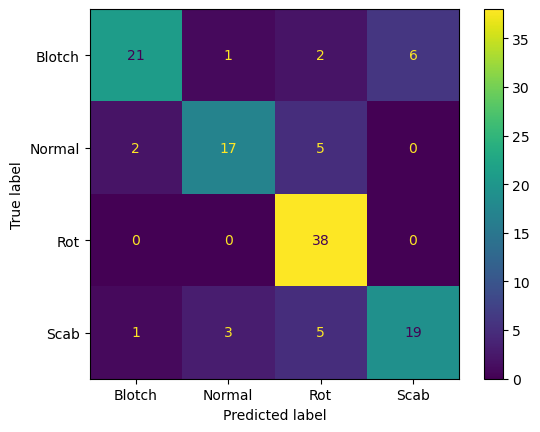

In [302]:

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

batchPredictions = model.predict(test_ds)
predicted_categories = tf.argmax(batchPredictions, axis=1)
true_categories = tf.concat([y for x, y in test_ds], axis=0)

confusion_matrix(predicted_categories, true_categories)

confusion_matrix = confusion_matrix(true_categories, predicted_categories)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,display_labels = ['Blotch', 'Normal', 'Rot', 'Scab'])

cm_display.plot()
# plt.savefig('saved_models/tl_mobileNetV2_2/plt_matrix/tl_matrix_' + str(dt_save) + '_' + str(time_save) + '_' + str(sc_model) + '.png')
plt.show()


###### <h4>Evaluatie en voorspelling</h4>

In [303]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

8/8 [==============================] - 2s 264ms/step - loss: 0.6193 - accuracy: 0.7917
Test accuracy : 0.7916666865348816


In [304]:
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

# plt.figure(figsize=(10, 10))
# for i in range(16):
#     ax = plt.subplot(4, 4, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")

Predictions:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Labels:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [305]:
image_batch, label_batch = apples_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

# plt.figure(figsize=(10, 10))
# for i in range(16):
#     ax = plt.subplot(4, 4, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")

Predictions:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Labels:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [322]:
vector = np.vectorize(np.int_)
y = np.array([2, 4, 6, 8])
x = vector(y)

print(x)
print(y)
# [2, 4, 6, 8]

[2 4 6 8]
[2 4 6 8]


In [325]:
img = keras.preprocessing.image.load_img(
    "../data/80apples/naamloze map/1832065205.jpg", target_size=img_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 1)  # Create batch axis
vectorApple = np.vectorize(np.int_)
predictions = model.predict(vectorApple)

applePredict = float(predictions[0])
print(applePredict)

ValueError: Failed to find data adapter that can handle input: <class 'numpy.vectorize'>, <class 'NoneType'>

<h2><a herf='https://keras.io/examples/vision/image_classification_from_scratch/' target='_blank' >Zie <strong>link</strong></a></h2>

In [ ]:
# run Tensorbord
%tensorboard --logdir logs/